# Quaternion convolutional layers reproduction

Firstly I want to check if it possible to recreate the paper. This process will consist of the following steps

- Dataloader
- DataFormatter
- QCNN import 
- QNN import
- Recreate archtitecture 
- Train

# Questions for the following session

- Where does the conversion to quaternions happen
- When we input the output feautures map into the Qlinearlayer we lose all our information right
- Why do de images needed te be padded with a extra dimension

# To do following session

- Train the network

## Modules


In [22]:
import numpy as np
import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import core_qnn as qcnn
import torch
import torch.nn as nn
from   torch.nn import Parameter
from   torch.nn import functional as F
import torch.optim
from   torch.autograd import Variable
from   torch import autograd
import os
import pickle
import numpy as np

## Dataloader

In [23]:
# Tranform data to PyTorch tensore
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

# Download the data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# Define the loaders
train_loader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_testset, batch_size=1000)

# Here we can add some data cleanup

Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([64, 3, 32, 32])


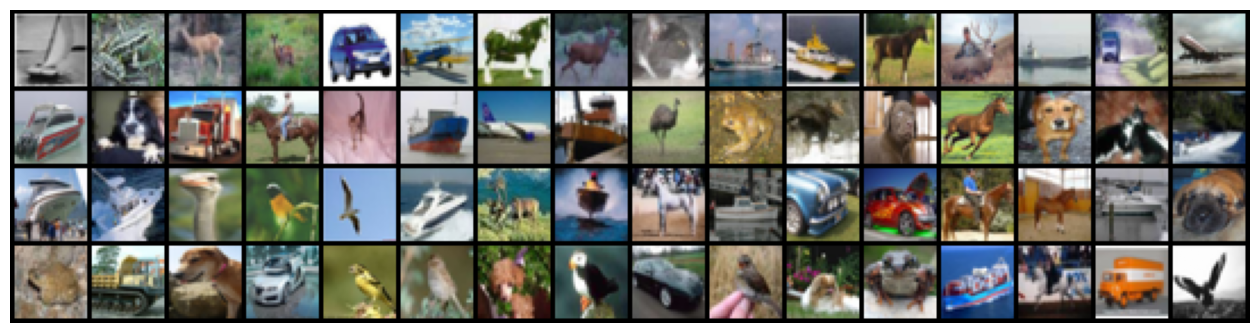

In [24]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

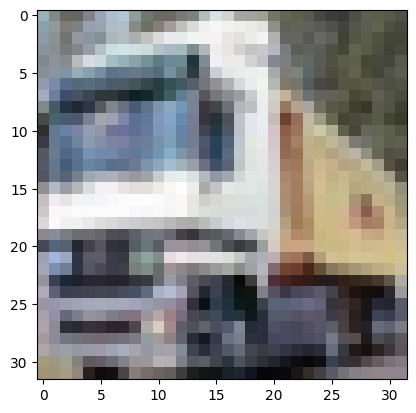

In [25]:
image, label  = cifar_trainset[1] 
plt.imshow(image.view(3,32,32).permute((1, 2, 0)))

## Dataformatter

In [59]:
batch_size = 32
num_classes = 10
epochs = 30
data_augmentation = True
num_predictions = 20

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'torch_cifar10_trained_model_Q.h5'

# Define the loaders 
train_loader_32 = DataLoader(cifar_trainset, batch_size=32, shuffle=True)
test_loader_32 = DataLoader(cifar_testset, batch_size=10000)

x_train = torch.cat([batch[0] for batch in train_loader], dim=0)
y_train = torch.cat([batch[1] for batch in train_loader], dim=0)

x_test = torch.cat([batch[0] for batch in test_loader], dim=0)
y_test = torch.cat([batch[1] for batch in test_loader], dim=0)

y_train = torch.nn.functional.one_hot(y_train, num_classes)
y_test = torch.nn.functional.one_hot(y_test, num_classes)

x_train /= 255
x_test /= 255
#add an extra dim with 0s
x_train = torch.cat([x_train, torch.zeros(50000, 1, 32, 32)], dim=1)

In [74]:
from   core_qnn.quaternion_layers import QuaternionLinear, QuaternionTransposeConv, QuaternionConv

model = th.nn.Sequential(QuaternionConv(in_channels=4, out_channels=32, kernel_size = 3, stride = 1, padding = 1),
                         nn.ReLU(),
                         QuaternionConv(in_channels=32, out_channels=32, kernel_size = 3, stride = 1, padding = 1),
                         th.nn.ReLU(),
                         nn.MaxPool2d(kernel_size=2, stride = 2),
                         nn.Dropout(0.25),

                        QuaternionConv(in_channels=32, out_channels=64, kernel_size = 3, stride = 1, padding = 1),
                        th.nn.ReLU(),
                        QuaternionConv(in_channels=64, out_channels=64, kernel_size = 3, stride = 1, padding = 1),
                        th.nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride = 2),
                        nn.Dropout(0.25),
    

                         nn.Flatten(),
                         nn.Linear(4096,512),
                         th.nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(512,10),
                         nn.Softmax()
                         )


In [75]:
i = 2

x_train_batch = x_train[i *32 : 32*(i + 1 )]
y_train_batch = y_train[i *32 : 32*(i + 1 )].to(torch.float)

# Forward pass
outputs = model(x_train_batch)

print(outputs)

tensor([[0.0963, 0.1013, 0.1007, 0.1031, 0.0967, 0.1003, 0.0962, 0.1011, 0.1025,
         0.1018],
        [0.0966, 0.1009, 0.1003, 0.1032, 0.0964, 0.1004, 0.0963, 0.1013, 0.1030,
         0.1017],
        [0.0970, 0.1015, 0.1013, 0.1028, 0.0968, 0.1001, 0.0961, 0.1010, 0.1023,
         0.1011],
        [0.0964, 0.1011, 0.1009, 0.1026, 0.0966, 0.1008, 0.0963, 0.1010, 0.1029,
         0.1015],
        [0.0963, 0.1015, 0.1009, 0.1029, 0.0964, 0.1005, 0.0968, 0.1009, 0.1026,
         0.1014],
        [0.0961, 0.1013, 0.1011, 0.1033, 0.0970, 0.0999, 0.0959, 0.1009, 0.1030,
         0.1014],
        [0.0966, 0.1012, 0.1012, 0.1034, 0.0965, 0.0999, 0.0961, 0.1012, 0.1025,
         0.1016],
        [0.0961, 0.1009, 0.1007, 0.1028, 0.0966, 0.1004, 0.0968, 0.1005, 0.1034,
         0.1018],
        [0.0963, 0.1018, 0.1011, 0.1034, 0.0969, 0.0993, 0.0959, 0.1016, 0.1027,
         0.1010],
        [0.0971, 0.1010, 0.1008, 0.1028, 0.0965, 0.1001, 0.0961, 0.1012, 0.1027,
         0.1016],
        [0

In [76]:
len(y_train)/32

1562.5

## Training the network (still needs to be done)



In [79]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr = 0.0001, weight_decay=1e-6)

num_epochs =  3
for epoch in range(num_epochs):
    
    # Let's create an batch
    for i in  range(int(50000/32)):
        opt.zero_grad()
        x_train_batch = x_train[i *32 : 32*(i + 1 )]
        y_train_batch = y_train[i *32 : 32*(i + 1 )].to(torch.float)
      
        # Forward pass
        outputs = model(x_train_batch)
        

        loss = criterion(outputs.view(-1), y_train_batch.view(-1))

        # Backward and optimize

        loss.backward()
        opt.step()

    # Print progress
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'
               .format(epoch+1, num_epochs, loss.cpu().item()))

Epoch [1/3], Loss: 184.5916
Epoch [2/3], Loss: 184.5879
Epoch [3/3], Loss: 184.5858
